### Calibration of wave gauge with temperature compensation ###

See other version in D:\Work\_Python3\And0K\tcm_cnv!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path
import sys


In [2]:
# Load data

# Custom importing function
# importing my functions
drive_d = 'D:' if sys.platform == 'win32' else '/mnt/D'  # to run on my Linux/Windows systems both
scripts_path = Path(drive_d + '/Work/_Python3/And0K/h5toGrid/inclinometer')
sys.path.append(str(Path(scripts_path).resolve()))
from csv_load import load_from_csv_gen


path_in = Path(r'd:\WorkData\_experiment\inclinometer\230425_Грузопоршневой\P\INKL_P*.TXT')

for i, probe_id, path_csv, df_raw in load_from_csv_gen({'in': {'dir': path_in.parent, 'mask': path_in.mask}}):
    break

AttributeError: 'WindowsPath' object has no attribute 'mask'

In [195]:
# Probe mean values of recorded voltage, V and temperature, °C:
u = [1849660.6693944354,
3860225.026666667,
4854919.607407408,
1900765.9244966444,
4837516.648275862,
3850900.5529411766,
4827934.222222222,
3841864.2,
4816303.533333333,
3834839.5565217393,
4804418.110169492,
1879658.6861313868
]
t = [
21.840147299509006,
3.6073333333333335,
3.505259259259259,
2.7269463087248327,
5.238137931034483,
5.791411764705882,
5.840962962962964,
6.979565217391306,
7.08506666666667,
8.220434782608697,
8.280423728813556,
9.907372262773722
]
# u = [[0.862565, 1.67355], [0.846437, 1.65218], [0.822848, 1.61338]]  # Voltage
# t = [[1.74295, 2.16332], [8.63737, 8.73015], [19.1236, 19.2093]]     # Temperature
x_values = np.column_stack((np.ravel(u), np.ravel(t)))

# Atmospheric pressure, dBar:
y_a = 1008.5/100  # 1008.5 hPa
# Real pressure, dBar:
ref_possible = np.float64([0, 1, 1.5])
y = [ref_possible[argmin(abs(ref_possible - p))] for p in 
     min(ref_possible) + (max(ref_possible) - min(ref_possible))*(tofit_P - min(tofit_P))/(max(tofit_P) - min(tofit_P))
    ]
# y = y_a + np.array([[0, 1*9.80665]]*3)  # converted from source values [0, 1 kg/cm2]
y_values = y.flatten()
print('Probe real pressure, dBar:\n', y_values)

print(f'Recordings ({x_values.shape} samples x features):\n', x_values)

Probe real pressure, dBar:
 [10.085   19.89165 10.085   19.89165 10.085   19.89165]
Recordings ((6, 2) samples x features):
 [[ 0.862565  1.74295 ]
 [ 1.67355   2.16332 ]
 [ 0.846437  8.63737 ]
 [ 1.65218   8.73015 ]
 [ 0.822848 19.1236  ]
 [ 1.61338  19.2093  ]]


In [196]:
# from scipy.optimize import curve_fit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#define our polynomial model, with whatever degree we want
degree=1

# PolynomialFeatures will create a new matrix consisting of all polynomial combinations 
# of the features with a degree less than or equal to the degree we just gave the model (2)
poly_model = PolynomialFeatures(degree=degree)

# transform out polynomial features
poly_x_values = poly_model.fit_transform(x_values)

# For degree=2 should be in the form [1, a, b, a^2, ab, b^2]
# print(f'initial values {x_values[0]} mapped to:\n{poly_x_values[0]}')

# Fit the model
poly_model.fit(poly_x_values, y_values)

# we use linear regression as a base!!! ** sometimes misunderstood **
regr = LinearRegression()

regr.fit(poly_x_values, y_values)

#print(poly_x_values)

y_pred = regr.predict(poly_x_values)
print(f'Coefficients of {poly_model.get_feature_names_out()[1:]}:', f"[{', '.join(str(k) for k in ([regr.intercept_] + regr.coef_[1:].tolist()))}]")

mse = mean_squared_error(y_values, y_pred, squared=False)
print('Mean squared error:', mse)

Coefficients of ['x0' 'x1' 'x2']: [-0.5684429466338461, 12.210978897907651, 0.03544690659204379]
Mean squared error: 0.05514829917444832


u(min,max): 0.822848 1.67355 t(min,max): 1.74295 19.2093 P(min,max): 10.085 19.89165
Errors of fit for experiments with different mean temperature:
2.0: [ 0.05889775 -0.05227379]
8.7: [ 0.01145055 -0.02409898]
19.2: [-0.07220908  0.07823355]


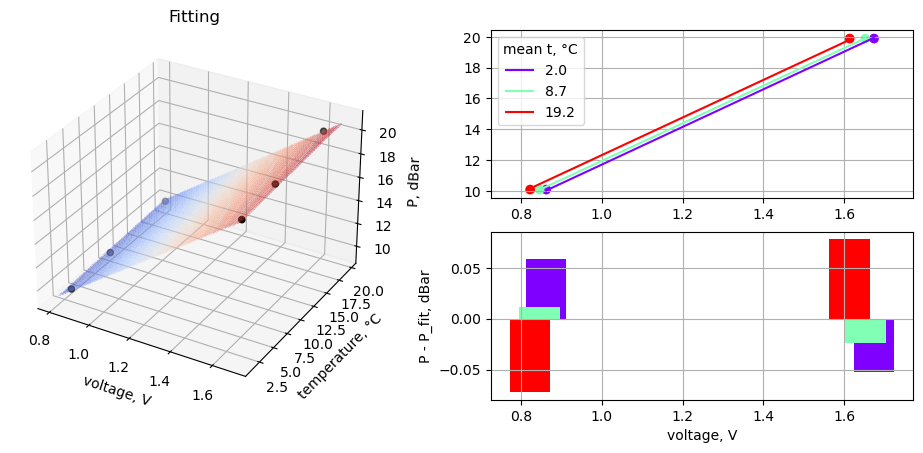

In [197]:
# Show plots 
%matplotlib inline  # is it realy changes something in juputerlab
fig = plt.figure(figsize=plt.figaspect(0.4))
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 4, sharex=ax2)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

# Plot result surface
u_min, u_max, t_min, t_max, P_min, P_max = np.min(u), np.max(u), np.min(t), np.max(t), np.min(y_values), np.max(y_values)
print('u(min,max):', u_min, u_max, 't(min,max):', t_min, t_max, 'P(min,max):', P_min, P_max)
ptp_u, ptp_t = u_max - u_min, t_max - t_min
n = 50
X = np.linspace(u_min - ptp_u/n, u_max + ptp_u/n, n)
Y = np.linspace(t_min - ptp_t/n, t_max + ptp_t/n, n)
X, Y = np.meshgrid(X, Y)
Z_in = np.column_stack((X.ravel(), Y.ravel()))
Z = regr.predict(poly_model.fit_transform(Z_in)).reshape(X.shape)
surf = ax1.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.2)
ax1.scatter3D(*x_values.T, y_values, color='k')
ax1.set_xlabel('voltage, V')
ax1.set_ylabel('temperature, °C')
ax1.set_zlabel('P, dBar')  # pressure
ax1.set_title('Fitting');

# Plot predictions lines for each sub experiment in assumption that external values changes linear between fitting points
# experiment's colors
c_experiments = cm.rainbow(np.linspace(0, 1, y.shape[0]))
# fitting points
ax2.scatter(x_values[:,0], y_values, c=np.repeat(c_experiments, y.shape[1], axis=0))
# predictions
print('Errors of fit for experiments with different mean temperature:')
for u_exp, t_exp, y_exp, c_exp in zip(u, t, y, c_experiments):
    # print(u_exp, t_exp)
    u_min, u_max, t_min, t_mean, t_max = np.min(u_exp), np.max(u_exp), np.min(t_exp), np.mean(t_exp), np.max(t_exp)
    # print('u(min,max):', u_min, u_max, 't(min,max):', t_min, t_max)
    X = np.linspace(u_min, u_max , n)
    Y = np.linspace(t_min, t_max , n)
    Z_in = np.column_stack((X, Y))
    Z = regr.predict(poly_model.fit_transform(Z_in))
    Z_bad = regr.intercept_ + (regr.coef_[1:] * Z_in).sum(axis=1)
    np.testing.assert_array_equal(Z, Z_bad)
    
    ax2.plot(X, Z, color=c_exp, label=f'{t_mean:.1f}')
    
    z_diff = y_exp - regr.predict(poly_model.fit_transform([[u_min, t_min], [u_max, t_max]]))
    print(f'{t_mean:.1f}:', z_diff)
    
    ax3.bar([u_min, u_max], z_diff, width=0.1, color=c_exp)
    ax3.set_xlabel('voltage, V')
    ax3.set_ylabel('P - P_fit, dBar')
ax2.legend(title='mean t, °C')
ax2.grid()
ax3.grid()

In [191]:
# Use formula for other data
u = [0.841866, 0.926501, 1.00791, 1.08949, 1.17089, 1.25182]
t = [15.0949, 15.0421, 14.9854, 14.9287, 14.884, 14.8525]
# Atmospheric pressure, dBar:
y_a = 1013/100  # 1008.5 hPa
# Real pressure, dBar:
y = y_a + np.append(0, np.arange(1.045, 1.045*(5 + 0.0001), 1.000))  # *9.80665
z = regr.predict(poly_model.fit_transform(np.column_stack((u, t))))
np.column_stack((y, z, y - z))

[10.24663252 11.27823713 12.27031087 13.26447269 14.25686189 15.24397984]


array([[10.13      , 10.24663252, -0.11663252],
       [11.175     , 11.27823713, -0.10323713],
       [12.175     , 12.27031087, -0.09531087],
       [13.175     , 13.26447269, -0.08947269],
       [14.175     , 14.25686189, -0.08186189],
       [15.175     , 15.24397984, -0.06897984]])

In [ ]:
# display fitted polynom formula (not tried)
def join_txt(text,delim='*'):
    return np.asarray(delim.join(text),dtype=object)

if True: 
    variable_names=poly.get_feature_names_out(X.columns)
    variable_names=np.core.defchararray.replace(variable_names.astype(str),' ','*')    

    fit_coeffs=["{:0.5g}".format(x) for x in fit.coef_]

    arr_list=[fit_coeffs,variable_names]
    fit_equation=np.apply_along_axis(join_txt, 0, arr_list)
    fit_equation='+'.join(fit_equation)
    fit_equation=fit_equation.replace("*1+","+")
    fit_equation=fit_equation.replace("+-","-")

    print("Fit equation:")    
    print(fit_equation)

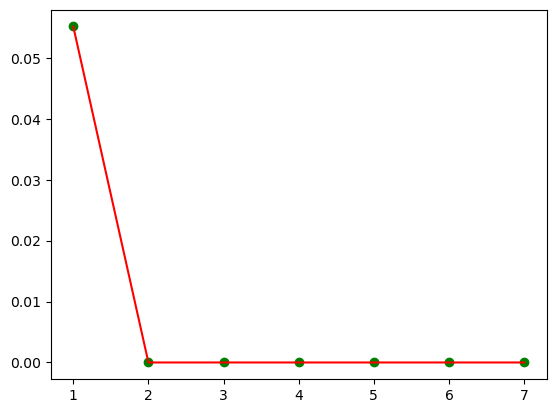

In [46]:
# check our accuracy for each degree, the lower the error the better!
number_degrees = [1,2,3,4,5,6,7]
plt_mean_squared_error = []
for degree in number_degrees:

   poly_model = PolynomialFeatures(degree=degree)
  
   poly_x_values = poly_model.fit_transform(x_values)
   poly_model.fit(poly_x_values, y_values)
  
   regression_model = LinearRegression()
   regression_model.fit(poly_x_values, y_values)
   y_pred = regression_model.predict(poly_x_values)
  
   plt_mean_squared_error.append(mean_squared_error(y_values, y_pred, squared=False))
  
plt.scatter(number_degrees,plt_mean_squared_error, color="green")
plt.plot(number_degrees,plt_mean_squared_error, color="red") 